In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [3]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73027 sha256=ad99eb50656c3de4bfff9be2976457df8706f718991c442eda47db70ea1f88cf
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d aadityasinghal/facial-expression-dataset -p /content/dataset_directory

facial-expression-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

with zipfile.ZipFile('/content/dataset_directory/custom_dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dataset_directory')

In [9]:
TRAIN_DIR = '/content/dataset_directory/custom_dataset/train/'
TEST_DIR = '/content/dataset_directory/custom_dataset/test/'

In [10]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [11]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

noassist Completed
assist Completed


,image,label
0,/content/dataset_directory/custom_dataset/trai...,assist
1,/content/dataset_directory/custom_dataset/trai...,noassist
2,/content/dataset_directory/custom_dataset/trai...,assist
3,/content/dataset_directory/custom_dataset/trai...,assist
4,/content/dataset_directory/custom_dataset/trai...,assist


In [12]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

noassist Completed
assist Completed


,image,label
0,/content/dataset_directory/custom_dataset/test...,noassist
1,/content/dataset_directory/custom_dataset/test...,noassist
2,/content/dataset_directory/custom_dataset/test...,noassist
3,/content/dataset_directory/custom_dataset/test...,noassist
4,/content/dataset_directory/custom_dataset/test...,noassist


<Axes: xlabel='count', ylabel='label'>

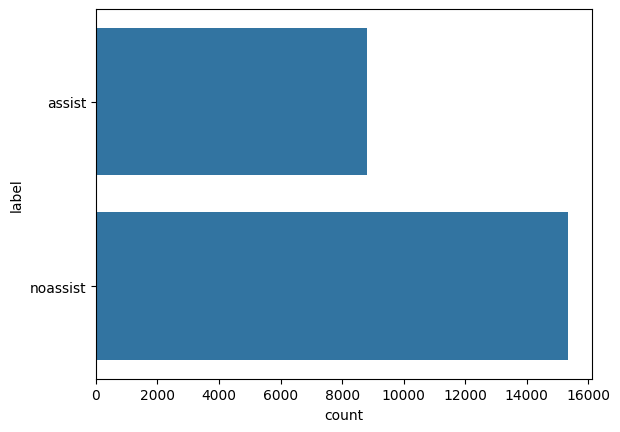

In [13]:
sns.countplot(train['label'])

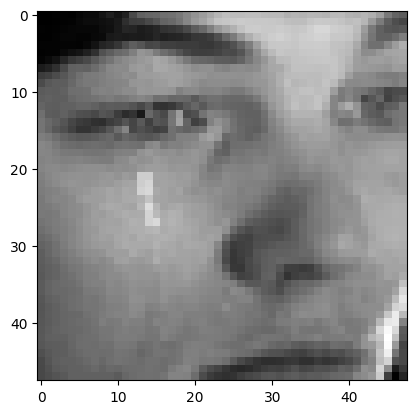

In [14]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')

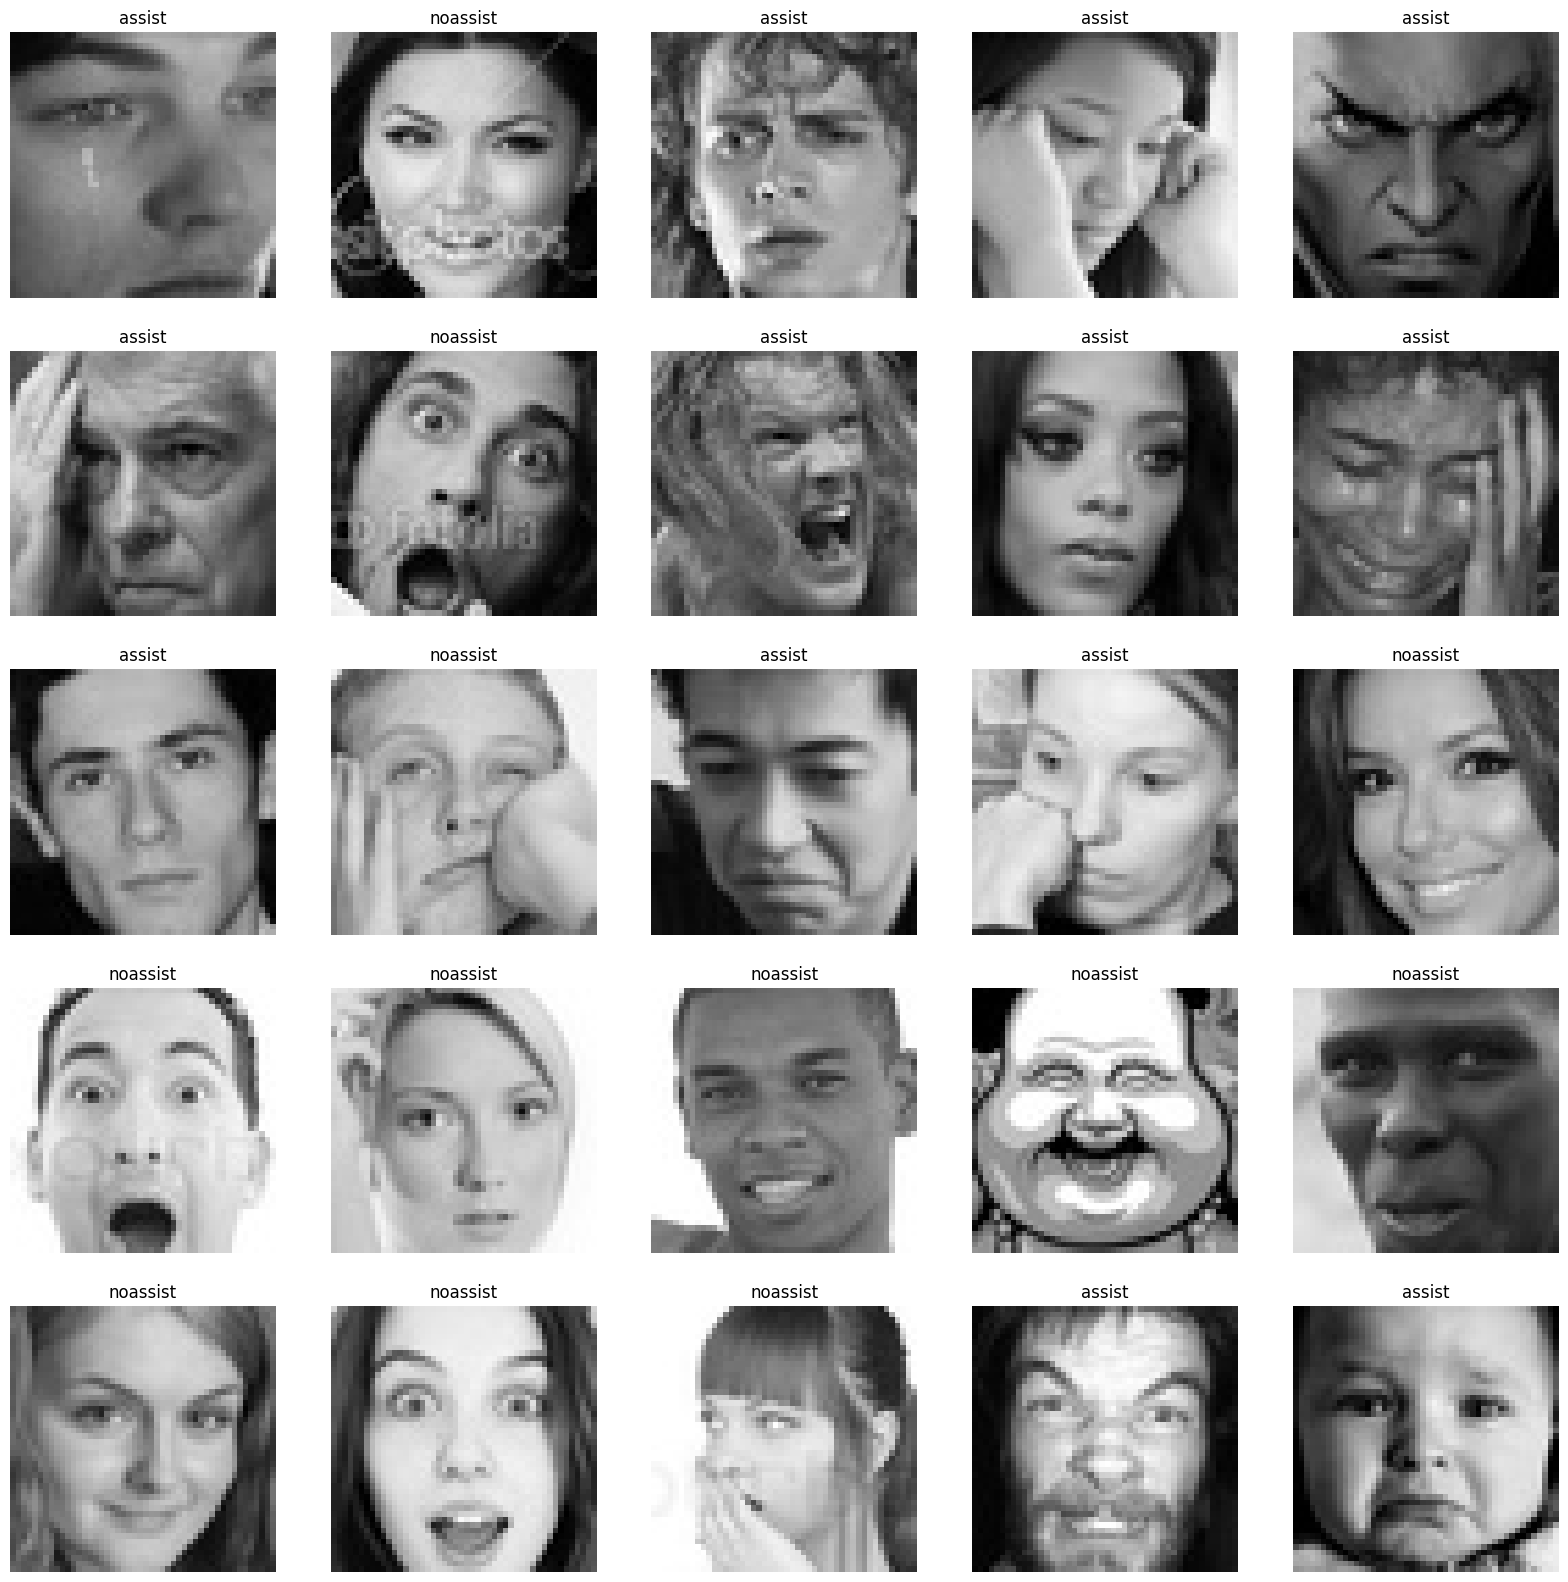

In [15]:
files = shuffle(train.iloc[0:25])

plt.figure(figsize=(20, 20))

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()

In [16]:
!pip install tqdm
from tqdm import tqdm

In [17]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = Image.open(image).convert('L')
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 48,48,1)
  return features

In [18]:
train_features = extract_features(train['image'])

100%|██████████| 24175/24175 [00:10<00:00, 2220.07it/s]


In [19]:
test_features = extract_features(test['image'])

100%|██████████| 6043/6043 [00:02<00:00, 2345.18it/s]


In [20]:
x_train = train_features/255.0
x_test = test_features/255.0

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test= le.transform(test['label'])

In [22]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [29]:
input_shape = (48,48,1)
output_class = 2

In [30]:
model = Sequential()

#CNN Layers

#Layer 1
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

#Layer 2
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

#Layer 3
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

#Layer 4
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))


model.add(Flatten())

#Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

#O/P Layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test,y_test))

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.6271 - loss: 0.6680 - val_accuracy: 0.6351 - val_loss: 0.6433
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6377 - loss: 0.6450 - val_accuracy: 0.6437 - val_loss: 0.6385
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.6482 - loss: 0.6327 - val_accuracy: 0.6623 - val_loss: 0.6141
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6583 - loss: 0.6216 - val_accuracy: 0.6760 - val_loss: 0.5998
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.6744 - loss: 0.6041 - val_accuracy: 0.6767 - val_loss: 0.5930
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.6826 - loss: 0.5914 - val_accuracy: 0.7175 - val_loss: 0.5530
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7042 - loss: 0.5646 - val_accuracy: 0.7208 - val_loss: 0.5519
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7063 - loss: 0.5556

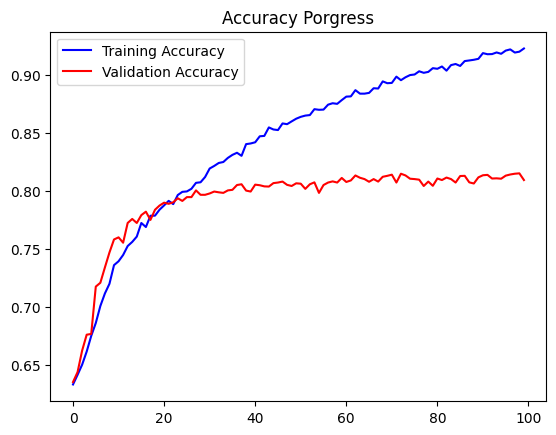

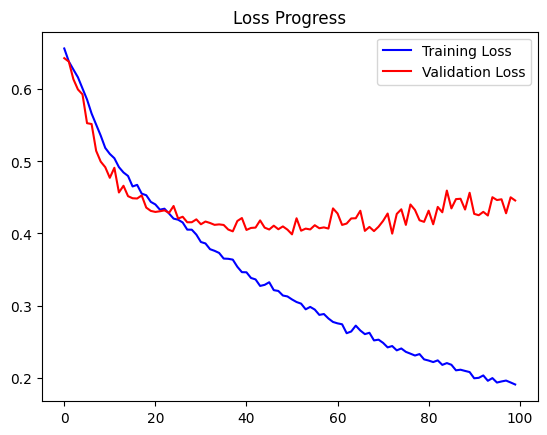

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs,val_acc,'r', label='Validation Accuracy')
plt.title('Accuracy Porgress')
plt.legend()
plt.figure()


loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs, val_loss, 'r',label='Validation Loss')
plt.title('Loss Progress')
plt.legend()

plt.show()

In [35]:
import random

Original Output:  noassist
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
Predicted Output:  noassist


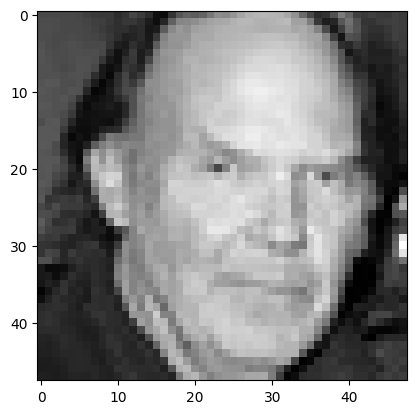

In [36]:
le.fit(test['label'])

image_index = random.randint(0, len(test) - 1)
print("Original Output: ", test['label'][image_index])


pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]

print("Predicted Output: ", prediction_label)


plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
plt.show()


In [37]:
model_json = model.to_json()
with open("facialemotionmodel.json", "w") as json_file:
    json_file.write(model_json)

In [38]:
model.save_weights("facialemotionmodel_weights.weights.h5")

In [40]:
from google.colab import files
files.download('facialemotionmodel.json')
# files.download('facialemotionmodel_weights.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>